### Youtube 댓글 크롤링 & 분석(검색어: 타다 금지법)

#### 1. 크롤링 대상: 이번달에 '타다 금지법'으로 업로드 된 동영상
#### - 데이터: 사용자 id, 댓글, 좋아요 수

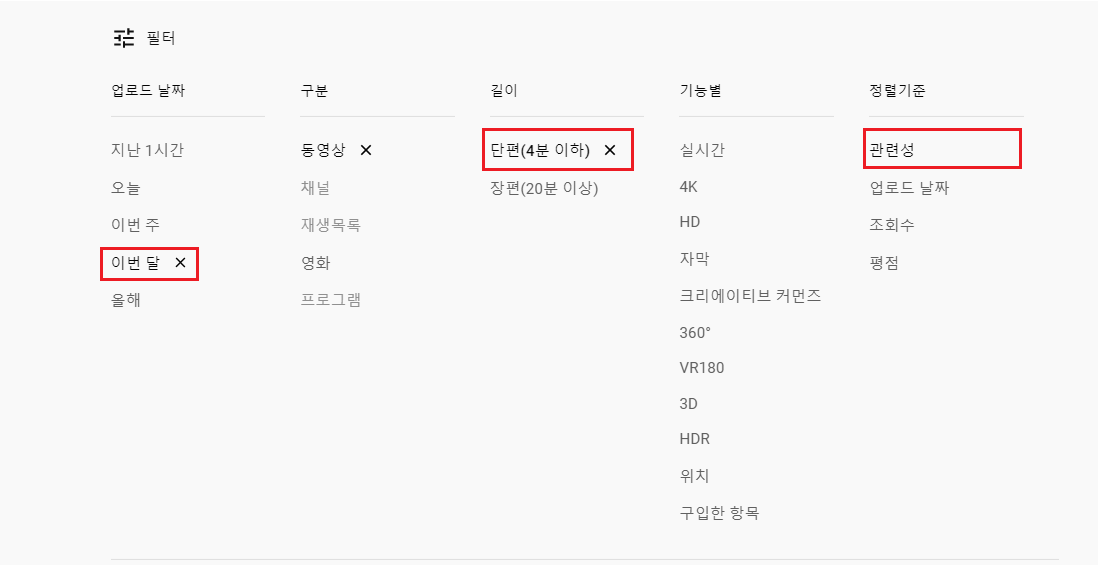

In [1]:
#유튜브 첫 화면
from PIL import Image as pil
main_page = pil.open("youtube/month.png")
main_page

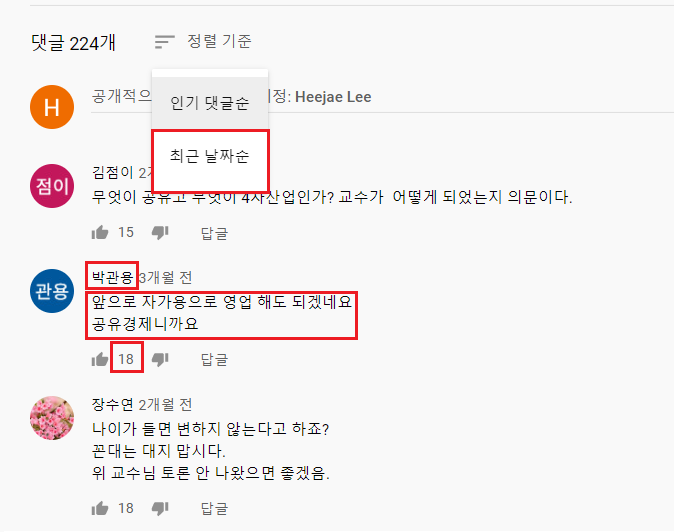

In [2]:
# 상세 화면(최근 날짜 순으로 정렬 후 댓글 가져오기)
page = pil.open("youtube/page.png")
page

### 2. Scrapy Code 

#### 1) 프로젝트 생성

In [3]:
!rm -rf youtube/

In [4]:
!scrapy startproject youtube

#### 2) items.py 작성

In [5]:
!cat youtube/youtube/items.py

In [6]:
%%writefile youtube/youtube/items.py

import scrapy

class YoutubeItem(scrapy.Item):
    title = scrapy.Field()
    user_id = scrapy.Field()
    comment = scrapy.Field()
    like_num = scrapy.Field()
    link = scrapy.Field()

Overwriting youtube/youtube/items.py


#### 3) spider.py 작성

In [7]:
%%writefile youtube/youtube/spiders/spider.py

import requests
import time
import scrapy

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from scrapy.http import TextResponse
from bs4 import BeautifulSoup
from youtube.items import YoutubeItem
from scrapy.spiders import Spider

class YoutubeCrawler(scrapy.Spider):
    item = YoutubeItem()
    name = "YoutubeCrawler"   
    allow_domains = ["youtube.com"]
    start_urls = ['https://www.youtube.com/results?search_query=타다 금지법&sp=EgYIBBABGAE%253D']
       
    def __init__(self):
        scrapy.Spider.__init__(self)
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome('/home/ubuntu/chromedriver', options=options)
        
    def parse(self, response):
        self.driver.get(response.url)
    
        time.sleep(2)
        page=self.driver.page_source

        soup = BeautifulSoup(page,'lxml')
        all_ = soup.find_all('a','yt-simple-endpoint style-scope ytd-video-renderer')
        
        #유튜브 첫 화면에서 이번달 업로드된 동영상 링크
        links= ["https://www.youtube.com/" + all_[n].get('href') for n in range(0,len(all_))]
        
        for link in links:
            yield scrapy.Request(link, callback=self.get_content)
        
    def get_content(self, response): #세부 링크 response
        time.sleep(10)
        self.driver.get(response.url)
        
        #모든 댓글 가져오기 위해, 페이지 스크롤 끝까지 내리기
        body = self.driver.find_element_by_tag_name("body")
        
        num_of_pagedowns = 30
        
        last_page_height = self.driver.execute_script("return document.documentElement.scrollHeight")

        while True: 
            self.driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);") 
            time.sleep(10.0) 
            new_page_height = self.driver.execute_script("return document.documentElement.scrollHeight") 
            
            if new_page_height == last_page_height: 
                break 
            
            last_page_height = new_page_height

        #댓글: 최근 날짜 순으로 정렬
            try: 
                self.driver.find_element_by_xpath('//*[@id="sort-menu"]').click() 
                self.driver.find_element_by_xpath('//*[@id="menu"]/a[2]/paper-item/paper-item-body/div[text()="최근 날짜순"]').click() 
        
            except Exception as e: 
                pass       
        
            #제목
            title = self.driver.find_element_by_css_selector('#container > h1 > yt-formatted-string').text
            #사용자 id    
            user_ids = self.driver.find_elements_by_css_selector('#author-text > span')
            #댓글
            comments = self.driver.find_elements_by_css_selector('#content-text')
            #좋아요 수
            like_nums = self.driver.find_elements_by_css_selector('#vote-count-middle')
            
        for j in range(0, len(comments)):    
            item = YoutubeItem()
            item["title"] = title
            item["comment"] = comments[j].text
            item["user_id"] = user_ids[j].text
            item["like_num"] = like_nums[j].text
            item["link"] = response.url
            
            yield item  

Overwriting youtube/youtube/spiders/spider.py


In [8]:
%%writefile run.sh
cd youtube
scrapy crawl YoutubeCrawler -o YoutubeCrawling.csv

Overwriting run.sh


In [10]:
!./run.sh

#### 4) pipeline.py 설정(pymongo 연결)

In [11]:
%%writefile youtube/youtube/mongodb.py 

import pymongo

client = pymongo.MongoClient('mongodb://ip:ip@ip.ip.ip.ip:ip')

db = client.youtube
collection = db.result2

Overwriting youtube/youtube/mongodb.py


In [12]:
!cat youtube/youtube/pipelines.py


import json
import requests
from .mongodb import collection

from .mongodb import collection

class YoutubePipeline(object):

    def process_item(self, item, spider):
        data = {"title": item["title"], 
                "user_id": item["user_id"], 
                "comment": item["comment"], 
                "like_num" : item["like_num"],
                "link": item["link"]}
        collection.insert(data)

        return item


In [9]:
%%writefile youtube/youtube/pipelines.py

from .mongodb import collection

class YoutubePipeline(object):

    def process_item(self, item, spider):
        data = {"title": item["title"], 
                "user_id": item["user_id"], 
                "comment": item["comment"], 
                "like_num" : item["like_num"]}
        collection.insert(data)

        return item

Overwriting youtube/youtube/pipelines.py


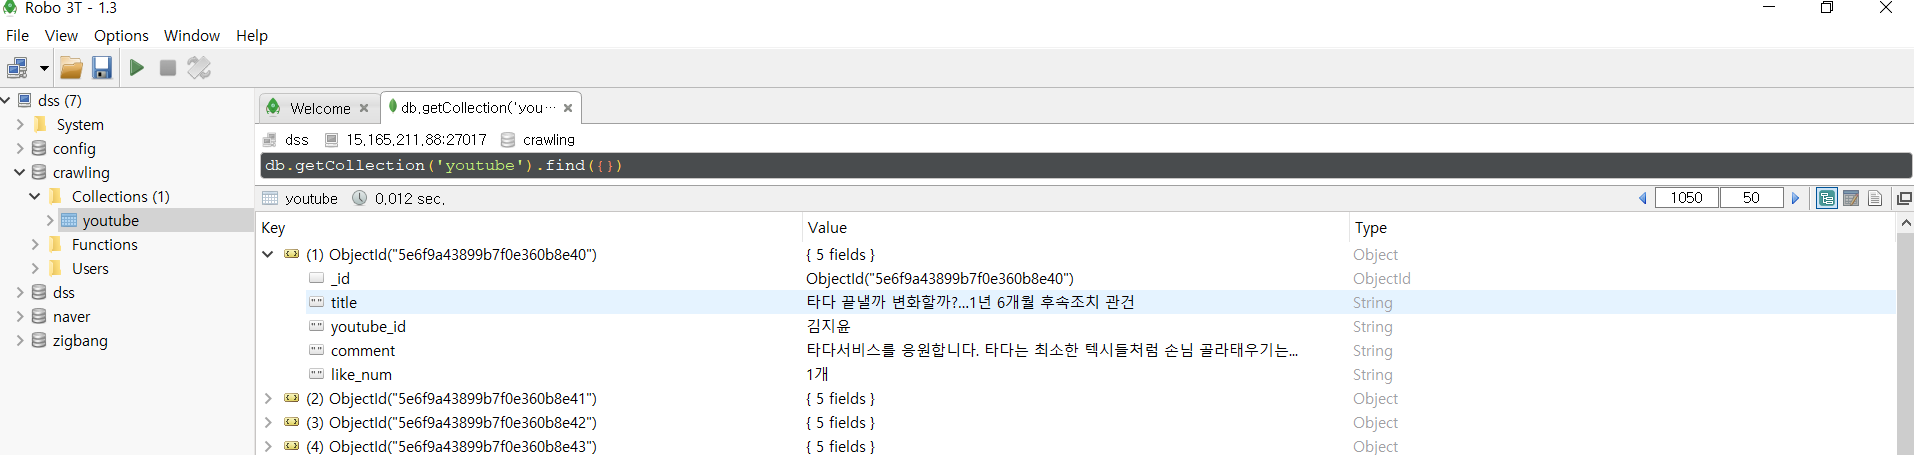

In [3]:
# 몽고 db 저장 결과
page = pil.open("youtube/mongodb.png")
page

In [ ]:
# settings.py 파일 수정
#ITEM_PIPELINES = {
    #'naver_article.pipelines.NaverArticlePipeline': 300,
#}

In [ ]:
#!./run.sh

2020-03-17 20:43:03 [scrapy.utils.log] INFO: Scrapy 1.8.0 started (bot: youtube)
2020-03-17 20:43:03 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.10.0, Python 3.6.9 (default, Jan 20 2020, 02:55:31) - [GCC 7.4.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Linux-4.15.0-1060-aws-x86_64-with-debian-buster-sid
2020-03-17 20:43:03 [scrapy.crawler] INFO: Overridden settings: {'BOT_NAME': 'youtube', 'FEED_FORMAT': 'csv', 'FEED_URI': 'YoutubeCrawling.csv', 'NEWSPIDER_MODULE': 'youtube.spiders', 'SPIDER_MODULES': ['youtube.spiders']}
2020-03-17 20:43:03 [scrapy.extensions.telnet] INFO: Telnet Password: 1112710ccb8e33f4
2020-03-17 20:43:03 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogSt

## 3. 댓글 분석

In [12]:
# koNLPy: 한국어 자연어 처리 패키지

from konlpy.tag import *  
from wordcloud import WordCloud

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from collections import Counter 
import pandas as pd

import pymongo
import sys

okt = Okt()
kkma = Kkma()

In [13]:
#몽고 DB에서 크롤링한 데이터 불러오기
client = pymongo.MongoClient("mongodb://ip:ip@ip.ip.ip.ip:ip")
result = client.crawling.youtube
comment_result = pd.DataFrame(result.find({}))
comment_result.tail()

,_id,comment,like_num,title,youtube_id
1279,5e6f9a43899b7f0e360b8f25,타다 유권자 보단 택시 유권자가 많으니.. 표를 얻으려면 어쩔수 없지...,1개,'타다 베이직' 4월 11일 중단…1만명 넘는 드라이버 어쩌나,김수면TV
1280,5e6f9a43899b7f0e360b8f26,불법 타다 옹호하는 애들아! \n택시가 그렇게 불편하고 서비스가 엉망이면 서비스가 ...,3개,'타다 베이직' 4월 11일 중단…1만명 넘는 드라이버 어쩌나,김건이
1281,5e6f9a43899b7f0e360b8f27,타다 패. 카카오 회사 승.\n타다 금지법 통과 됐다고 해서 택시가 이기는게 아님....,1개,'타다 베이직' 4월 11일 중단…1만명 넘는 드라이버 어쩌나,김건이
1282,5e6f9a43899b7f0e360b8f28,꽁으로 먹으려다 결국 이렇게 되었넹...,0개,'타다 베이직' 4월 11일 중단…1만명 넘는 드라이버 어쩌나,subinoh
1283,5e6f9a43899b7f0e360b8f29,사납금에 대해선 찍소리도 못하는 무식한 택시기사들.,1개,'타다 베이직' 4월 11일 중단…1만명 넘는 드라이버 어쩌나,민주국가대한민국


In [14]:
# like_num에서 '개' 단어 제거
a = comment_result['like_num']
b=[]
for i in range(0, len(a)):
    c = a[i].replace("개","")
    b.append(c)

len(b)

1284

In [15]:
#단어 연관성 분석 위해, 좋아요 수 많은 순으로 정렬
comment_result['like_co'] = b
comment_result['like_co'] = comment_result['like_co'].astype(int)
liek_co_up = comment_result.like_co >=1
comment_result_sort = comment_result.loc[liek_co_up, :]
comment_result_sort = comment_result_sort.sort_values(by='like_co', ascending=False)
comment_result_sort.head()
comment_sort = list(comment_result_sort['comment'])

In [16]:
comment_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 6 columns):
_id           1284 non-null object
comment       1284 non-null object
like_num      1284 non-null object
title         1284 non-null object
youtube_id    1284 non-null object
like_co       1284 non-null int64
dtypes: int64(1), object(5)
memory usage: 60.3+ KB


In [17]:
# 500개의 댓글만 추출
comment = list(comment_result['comment'])
comment_sample = comment[0:500]
comment_sample

['멍청한인간!대통령 등에업고 별 회괴한 짓거리를 다하는구나.노블리스오블리제!넌 도덕심도 양심도 없는 한낫 돈많은 괴물이야~',
 '법앞에는 만인이 평등한걸 알아아지...권력기생충들...',
 '혁신 ㅡ 지금도 택시회사나\n개인택시 ㅡ줄도산 위기 ㅡ\n타다 ㅡ 머여 ㅡ 자가용영업까지 한다고 ? ㅡ\n같이 죽자고  ?',
 '이재용 대표님에게 한 말씀 하겠습니다 그렇게 운수업을 하고 싶으면 지금 당장택시 회사나 개인택시면허을 사 가지고 그렇게정상적으로 운영을 하세요 왜 돈 한푼 안 들이고 그렇게 공짜로 하려고 그러니까 반발이 심한거 아닙니까~\n이재용대표님에목적은다른대있는거다압니다',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 '당연한거다 어디서 말장난으로 사가지없이',
 '수천 수만대 택시가 대기\n중 인대\n계속 대기 하고 있을까\n타다 당신도 번호판 4차\n5차 하면',
 "택시 서비스개선 수칙!\n나는 내 택시를 이용하는 승객에게 내가 이용한다는 생각으로 반대의 입장에서 운행한다!!\n\n1.내 영업구역 외 가급적 합법 승차거부도 줄인다\n2.내 택시는 항상 청결을 유지한다\n3.익숙하진 않지만 '안녕하세요','감사합니다 '\n   최대한 웃는 얼굴로 승객을 대한다\n4.승객의 짐은 내가 싣고 내려 드린다\n5.인사말 외 최대한 말을 줄인다\n6.카드 계산도 반갑게 받아 들인다\n7.내 택시가 운행할 수 있는 도로는 무조건\n   모신다\n8.절대 운행 중 전화는 사양한다\n9.과속및 난폭운전 NO 준법운행 한다\n10.용모단정!\n11.절대 영업구역 내 승차거부는 없다\n12.젊은 승객에게 반말하지 않기\n\n등등 수칙으로 정할 사항이 더 있을 듯 합니다\n택시 서비스개선만이 답임을 동참 해 나가시죠\n동료 선,후배님들 이제부터 시작입니다!\n우리 업권보호를 위한 모습!!파이팅입니다",
 'it하나 접목시킨거 빼고는 택시랑 다를게 없는데 워가 혁신이라는거지?',
 '택시 평점제 도입 국민청원. 아래 링크',
 '대한민국 자우시장국가맞지? ㅋㅋㅋ 택시만 경쟁하는 모습 

In [18]:
#NLP 분석 시 텍스트 형태로 불러와 작업해줘야 함.(파일 쓰는 함수)
def write_txt(list,fname,sep):
    file = open(fname,'w')
    vstr = ''
    
    for a in list:
        vstr = vstr + str(a) + sep
    vstr = vstr.rstrip(sep)
    
    file.writelines(vstr)
    
    file.close()
    print('[complete]')

In [19]:
write_txt(comment_sample,'wtest_samlpe.txt',sep="'")

com_txt = open('wtest_samlpe.txt').read()

# 추출된 단어 확인
word_ext = okt.nouns(com_txt)
print(word_ext)

[complete]
['인간', '대통령', '등', '별', '회', '괴한', '짓거리', '노블', '리스', '블', '리제', '넌', '도덕', '양심', '낫', '돈', '괴물', '법앞', '만인', '걸', '권력', '기생충', '혁신', '지금', '택시', '회사', '개인', '택시', '줄', '도산', '위기', '머', '자가용', '영업', '이재용', '대표', '말씀', '운수업', '지금', '당장', '택시', '회사', '개인', '택시', '사', '가지', '정상', '운영', '왜', '돈', '푼', '안', '공짜', '반발', '이재용', '대표', '목적', '압니', '말장난', '수천', '만대', '택시', '대기', '중', '인대', '계속', '대기', '당신', '번호판', '차', '차', '택시', '서비스', '개선', '수칙', '나', '내', '택시', '이용', '승객', '내', '이용', '생각', '반대', '입장', '운행', '내', '영업', '구역', '외', '합법', '승차', '거부', '내', '택시', '항상', '청결', '유지', '최대한', '얼굴', '승객', '대한', '승객', '짐', '내', '인사말', '외', '최대한', '말', '카드', '계산', '내', '택시', '운행', '수', '도로', '무조건', '절대', '운행', '중', '전화', '사양', '과속', '및', '난폭운전', '준법', '운행', '용모', '단정', '절대', '영업', '구역', '내', '승차', '거부', '승객', '반말', '등등', '수칙', '정', '사항', '더', '듯', '택시', '서비스', '개선', '답임', '동참', '해', '나가시', '동료', '선', '후배', '이제', '시작', '우리', '업', '보호', '위', '모습', '파이팅', '하나', '접목', '택시', '워', '혁신', '거지', '택시', '평

In [20]:
# 문장별 중복 단어를 제거하고 빈도수 구하기
word_freq = Counter(word_ext)
print(word_freq)

Counter({'택시': 243, '불법': 64, '법': 55, '기사': 54, '영업': 53, '혁신': 46, '사업': 45, '정부': 41, '것': 39, '생각': 38, '다가': 37, '차': 33, '돈': 31, '서비스': 31, '국민': 31, '면허': 31, '이재웅': 29, '왜': 27, '산업': 27, '말': 26, '나라': 25, '표': 24, '이': 23, '사람': 22, '합법': 20, '국회의원': 20, '거부': 19, '국회': 19, '판사': 18, '문제': 18, '금지': 18, '지금': 17, '더': 17, '사기꾼': 17, '기업': 17, '안': 16, '내': 16, '소리': 16, '렌터카': 16, '한국': 16, '금': 16, '거': 16, '회사': 15, '대한민국': 15, '콜': 15, '좀': 15, '때': 15, '이해': 15, '앱': 15, '대통령': 14, '승차': 14, '업체': 14, '임': 14, '개인': 13, '경쟁': 13, '개': 13, '운수': 13, '뭐': 13, '금지법': 13, '사서': 13, '시작': 12, '차량': 12, '그냥': 12, '운전': 12, '기존': 12, '방송': 12, '무슨': 12, '이용': 11, '카니발': 11, '신천지': 11, '사이비': 11, '데': 11, '카카오': 11, '국토부': 11, '호출': 11, '입장': 10, '이제': 10, '위': 10, '하나': 10, '아주': 10, '명': 10, '자': 10, '저': 10, '그': 10, '때문': 10, '이상': 10, '앞': 10, '상생': 10, '우버': 10, '무죄': 10, '모두': 10, '선택': 10, '번호판': 9, '진짜': 9, '이건': 9, '일자리': 9, '자동차': 9, '자격증': 9, '우리나라': 9, '제대로': 9, '손님

In [21]:
#명사, 조사 각 품사들 찾아내기
okt.pos(com_txt, join=True)

['멍청한/Adjective',
 '인간/Noun',
 '!/Punctuation',
 '대통령/Noun',
 '등/Noun',
 '에/Josa',
 '업고/Verb',
 '별/Noun',
 '회/Noun',
 '괴한/Noun',
 '짓거리/Noun',
 '를/Josa',
 '다/Adverb',
 '하는구나/Verb',
 './Punctuation',
 '노블/Noun',
 '리스/Noun',
 '오/Modifier',
 '블/Noun',
 '리제/Noun',
 '!/Punctuation',
 '넌/Noun',
 '도덕/Noun',
 '심도/Verb',
 '양심/Noun',
 '도/Josa',
 '없는/Adjective',
 '한/Determiner',
 '낫/Noun',
 '돈/Noun',
 '많은/Adjective',
 '괴물/Noun',
 '이야/Josa',
 "~'/Punctuation",
 '법앞/Noun',
 '에는/Josa',
 '만인/Noun',
 '이/Josa',
 '평등한/Adjective',
 '걸/Noun',
 '알아아지/Verb',
 '.../Punctuation',
 '권력/Noun',
 '기생충/Noun',
 '들/Suffix',
 "...'/Punctuation",
 '혁신/Noun',
 'ㅡ/KoreanParticle',
 '지금/Noun',
 '도/Josa',
 '택시/Noun',
 '회사/Noun',
 '나/Josa',
 '\n/Foreign',
 '개인/Noun',
 '택시/Noun',
 'ㅡ/KoreanParticle',
 '줄/Noun',
 '도산/Noun',
 '위기/Noun',
 'ㅡ/KoreanParticle',
 '\n/Foreign',
 '타다/Verb',
 'ㅡ/KoreanParticle',
 '머/Noun',
 '여/Josa',
 'ㅡ/KoreanParticle',
 '자가용/Noun',
 '영업/Noun',
 '까지/Josa',
 '한다고/Verb',
 '?/Punctuation',
 'ㅡ/KoreanPar

In [22]:
# 형태소 추출 하기. norm 은 문장 정규화 stem 은 어간 추출
print(okt.morphs(com_txt, norm=True))

['멍청한', '인간', '!', '대통령', '등', '에', '업고', '별', '회', '괴한', '짓거리', '를', '다', '하는구나', '.', '노블', '리스', '오', '블', '리제', '!', '넌', '도덕', '심도', '양심', '도', '없는', '한', '낫', '돈', '많은', '괴물', '이야', "~'", '법앞', '에는', '만인', '이', '평등한', '걸', '알아아지', '...', '권력', '기생충', '들', "...'", '혁신', 'ㅡ', '지금', '도', '택시', '회사', '나', '\n', '개인', '택시', 'ㅡ', '줄', '도산', '위기', 'ㅡ', '\n', '타다', 'ㅡ', '머', '여', 'ㅡ', '자가용', '영업', '까지', '한다고', '?', 'ㅡ', '\n', '같이', '죽자고', "?'", '이재용', '대표', '님', '에게', '한', '말씀', '하겠습니다', '그렇게', '운수업', '을', '하고', '싶으면', '지금', '당장', '택시', '회사', '나', '개인', '택시', '면', '허을', '사', '가지', '고', '그렇게', '정상', '적', '으로', '운영', '을', '하세요', '왜', '돈', '한', '푼', '안', '들이고', '그렇게', '공짜', '로', '하려고', '그러니까', '반발', '이', '심한거', '아닙니까', '~', '\n', '이재용', '대표', '님', '에', '목적', '은', '다른대', '있는거다', '압니', '다', "'", 'ㅋㅋㅋ', "'", '당연한거다', '어디서', '말장난', '으로', '사가지', '없이', "'", '수천', '수', '만대', '택시', '가', '대기', '\n', '중', '인대', '\n', '계속', '대기', '하고', '있을까', '\n', '타다', '당신', '도', '번호판', '4', '차', '\n', '5', '차', '하면

In [23]:
# 어절 추출
print(okt.phrases(com_txt))

['멍청한인간', '대통령', '대통령 등', '별 회괴한', '별 회괴한 짓거리', '노블리스오블리제', '넌 도덕', '양심', '없는 한낫', '없는 한낫 돈', '없는 한낫 돈많은 괴물', '법앞', '만인', '평등한걸', '권력기생충들', '혁신', '지금', '택시회사', '개인택시', '줄도산', '줄도산 위기', '자가용영업', '이재용', '이재용 대표님', '말씀', '운수업', '지금 당장택시', '지금 당장택시 회사', '사 가지', '운영', '왜 돈 한푼', '왜 돈 한푼 안', '공짜', '반발', '이재용대표님', '목적', '압니', '말장난', '수천', '수천 수만대', '수천 수만대 택시', '대기', '중 인대', '계속', '계속 대기', '당신', '번호판', '번호판 4차', '5차', '택시', '택시 서비스개선', '택시 서비스개선 수칙', '내 택시', '이용', '이용하는 승객', '이용한다는', '이용한다는 생각', '반대', '반대의 입장', '운행', '내 영업구역', '내 영업구역 외', '합법', '합법 승차거부', '항상', '항상 청결', '유지', '최대한', '최대한 웃는 얼굴', '승객', '대한', '승객의 짐', '인사말', '인사말 외', '인사말 외 최대한', '인사말 외 최대한 말', '카드', '카드 계산', '운행할 수', '운행할 수 있는 도로', '무조건', '절대', '절대 운행', '절대 운행 중', '절대 운행 중 전화', '사양', '과속및', '과속및 난폭운전', '과속및 난폭운전 NO', '과속및 난폭운전 NO 준법운행', '10', '용모단정', '11', '절대 영업구역', '절대 영업구역 내', '절대 영업구역 내 승차거부', '12', '젊은 승객', '반말', '등등', '등등 수칙', '정할 사항', '더 있을 듯', '답임', '동참', '동참 해', '동참 해 나가시', '동료', '동료 선', '후배님', '후배님들 이제', '시작', '우리', '

In [24]:
# 만약 각 줄별로 동일한 단어가 나올 경우 제거 하고 싶을 때
# 라인별로 읽어야 하기 때문에  open -> readline을 쓴다.
com_txt = open('wtest_samlpe.txt').readlines()
duplicate_comment = []

for i in com_txt:
    duplicate_comment1 = kkma.nouns(i)
    for j in range(0,len(duplicate_comment1)):
        duplicate_comment.append(duplicate_comment1[j])
print(duplicate_comment)

['인간', '대통령', '등에', '등에업고', '업고', '별', '회', '회괴한', '괴한', '짓거리', '노', '리스', '리스오', '오', '리', '넌', '도덕심', '양심', '한', '한낫', '낫', '돈', '괴물', '법', '법앞', '앞', '만인', '평등', '아지', '권력', '권력기생충', '기생충', '혁신', 'ㅡ', '지금', '택시', '택시회사', '회사', '개인', '개인택시', '택시', 'ㅡ', 'ㅡ줄', '줄', '산', '위기', 'ㅡ', '여', '자가용', '자가용영업', '영업', '이재', '대표', '말씀', '운', '운수업', '수업', '당장', '당장택시', '택시', '회사', '개인', '개인택시면허', '면허', '사', '정상적', '운영', '하세', '돈', '푼', '안', '공짜', '반발', '거', '이재', '목적', '대', '대표', '거', '어디', '말장난', '사', '사가지', '가지', '수천', '수만', '수만대', '택시', '대기', '중', '인대', '계속', '대기', '당신', '번호판', '4', '4차', '차', '5', '5차', '차', '하면', '택시', '서비스', '서비스개선', '개선', '수칙', '내', '택시', '이용', '승객', '내가', '생각', '반대', '입장', '운행', '1', '내', '영업', '영업구역', '구역', '외', '합법', '승차', '승차거부', '거부', '2', '택시', '청결', '유지', '3', '안녕', '안녕하세', '하세', '감사', '얼굴', '승객', '4', '승객', '짐', '내가', '5', '인사말', '외', '최대', '말', '6', '카드', '계산', '7', '택시', '운행', '수', '도로', '8', '절대', '운행', '중', '전화', '사양', '9', '과속', '난폭', '난폭운전', '운전', '준법', '준법운행',

In [25]:
# 두 단어 이상의 글자만 선택하기
rm_dupl = []
for i in duplicate_comment:
    if len(i) >= 2:
        rm_dupl.append(i)

print(rm_dupl)

['인간', '대통령', '등에', '등에업고', '업고', '회괴한', '괴한', '짓거리', '리스', '리스오', '도덕심', '양심', '한낫', '괴물', '법앞', '만인', '평등', '아지', '권력', '권력기생충', '기생충', '혁신', '지금', '택시', '택시회사', '회사', '개인', '개인택시', '택시', 'ㅡ줄', '위기', '자가용', '자가용영업', '영업', '이재', '대표', '말씀', '운수업', '수업', '당장', '당장택시', '택시', '회사', '개인', '개인택시면허', '면허', '정상적', '운영', '하세', '공짜', '반발', '이재', '목적', '대표', '어디', '말장난', '사가지', '가지', '수천', '수만', '수만대', '택시', '대기', '인대', '계속', '대기', '당신', '번호판', '4차', '5차', '하면', '택시', '서비스', '서비스개선', '개선', '수칙', '택시', '이용', '승객', '내가', '생각', '반대', '입장', '운행', '영업', '영업구역', '구역', '합법', '승차', '승차거부', '거부', '택시', '청결', '유지', '안녕', '안녕하세', '하세', '감사', '얼굴', '승객', '승객', '내가', '인사말', '최대', '카드', '계산', '택시', '운행', '도로', '절대', '운행', '전화', '사양', '과속', '난폭', '난폭운전', '운전', '준법', '준법운행', '운행', '10', '용모', '용모단정', '단정', '11', '절대', '영업', '영업구역', '구역', '승차', '승차거부', '거부', '12', '승객', '반말', '등등', '수칙', '사항', '택시', '서비스', '서비스개선만이', '개선', '만이', '답임', '동참', '동료', '후배', '이제', '시작', '우리', '보호', '모습', '파이', '파이팅', '하나', '접목', '택시'

In [27]:
# 단어별 빈도수 집계 최종
result_freq = Counter(rm_dupl)
result_freq_mc = result_freq.most_common(100)
result_freq_mc_dict = dict(result_freq_mc)
print(result_freq_mc)

[('택시', 110), ('불법', 43), ('기사', 36), ('혁신', 31), ('생각', 29), ('나라', 28), ('영업', 25), ('면허', 24), ('서비스', 24), ('정부', 24), ('이재', 22), ('산업', 22), ('이재웅', 21), ('사업', 21), ('국회', 21), ('국민', 20), ('사람', 20), ('이것', 18), ('국회의원', 16), ('지금', 15), ('사기꾼', 15), ('사업법', 15), ('업체', 15), ('거부', 14), ('판사', 14), ('금지', 14), ('회사', 13), ('우리', 13), ('대한', 13), ('대한민국', 13), ('민국', 13), ('이해', 13), ('운전', 12), ('운수', 12), ('한국', 12), ('교통', 12), ('대통령', 11), ('합법', 11), ('시장', 11), ('국가', 11), ('차량', 11), ('이상', 11), ('여객', 11), ('기존', 11), ('기업', 11), ('호출', 11), ('승차', 10), ('승차거부', 10), ('경쟁', 10), ('소리', 10), ('카니발', 10), ('사이비', 10), ('통과', 10), ('문제', 10), ('때문', 10), ('금지법', 10), ('택시기사', 10), ('경제', 10), ('무죄', 10), ('사서', 10), ('5차산업', 10), ('앱으', 10), ('이용', 9), ('입장', 9), ('렌터카', 9), ('택시영업', 9), ('신천지', 9), ('총량', 9), ('지법', 9), ('4차산업', 9), ('선택', 9), ('개인', 8), ('도로', 8), ('시작', 8), ('자동차', 8), ('의원', 8), ('협박', 8), ('운송', 8), ('사납금', 8), ('이유', 8), ('총선', 8), ('가족', 8), ('영업용', 

#### 워드 클라우드

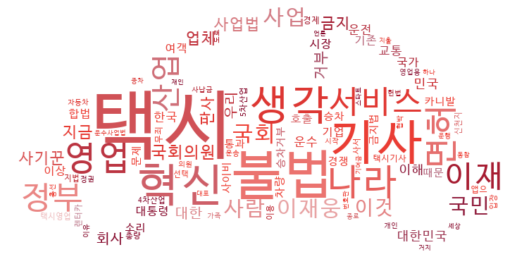

In [28]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()


alice_coloring = np.array(Image.open(path.join(d, 'youtube/car.jpg')))
stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(font_path = 'font/D2Coding.ttc', background_color='white',mask=alice_coloring,width=1500, height=1000)
wc.generate_from_frequencies(result_freq_mc_dict) 


image_colors = ImageColorGenerator(alice_coloring, default_color="hot")

plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
figure = plt.gcf() 
figure.set_size_inches(9, 8)
plt.axis('off') 

# 파일 저장 코드
plt.savefig('word_cloud_korea.png',dpi=500)
plt.show()

#### 단어 별 빈도수 plot

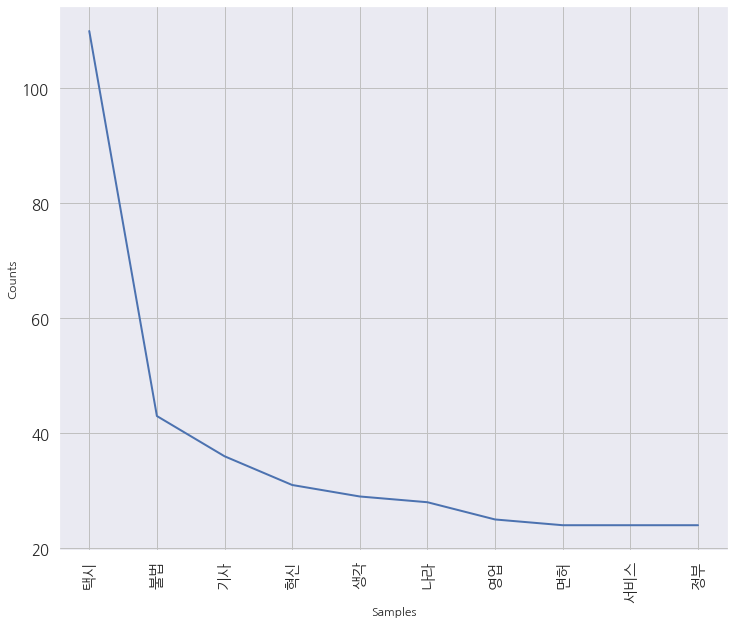

In [29]:
import nltk 
from nltk.probability import FreqDist 
import matplotlib as mpl

font_location = "font/NanumGothic-Regular.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font',family = font_name)
plt.figure(figsize=(12,10))
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

# 두 단어 이상의 글자만 선택한 데이터에서 빈도수 구하고 그려주기
graph_comm = FreqDist(rm_dupl) 
graph_comm.plot(10)

#### 단어별 네트워크 분석

In [30]:
from konlpy.tag import Hannanum
import re
import csv
from apyori import apriori
import networkx as nx

In [31]:
hannanum = Hannanum()

In [32]:
# 연관성 분석을 위해 댓글별로 단어 쪼개기
dataset = []
for i in range(len(comment_sort)):
    dataset.append(hannanum.nouns(re.sub('[^가-힣a-zA-Z\s]','',comment_sort[i])))
    
test_asso = dataset[:20]
test_asso

[['채이배', '이철희', '불법아니냐', '법좀제대', '국회의원해', '당신들', '이번', '마지막이지'],
 ['채이배', '이철희', '불법아니냐', '법좀제대', '국회의원해', '당신들', '이번', '마지막이지'],
 ['이의', '탕탕탕', '개그맨들', '분발', '개콘저리가라'],
 ['이의', '탕탕탕', '개그맨들', '분발', '개콘저리가라'],
 ['기업', '편', '손', '미통닭들', '금지', '이유', '신천지', '택시기사들', '표'],
 ['기업', '편', '손', '미통닭들', '금지', '이유', '신천지', '택시기사들', '표'],
 ['본질', '팍악하', '계시는거', '박수', '수'],
 ['본질', '팍악하', '계시는거', '박수', '수'],
 ['이철희', '너', '뭐냐미친'],
 ['뭘더', '토론할', '지금', '불법', '면허도', '사실상택시', '어디있냐', '랜터카', '영업', '것', '이법'],
 ['뭘더', '토론할', '지금', '불법', '면허도', '사실상택시', '어디있냐', '랜터카', '영업', '것', '이법'],
 ['이철희', '너', '뭐냐미친'],
 ['마음', '것', '회의', '결정내'],
 ['오신환의원', '진짜', '국회의원', '검토', '깊이', '대안', '제시', '상황파악', '되있구'],
 ['채이배이철이이처죽일놈들이래서니놈들이비래대표를잆애야한다는것'],
 ['채이배이철이이처죽일놈들이래서니놈들이비래대표를잆애야한다는것'],
 ['뭐', '분명'],
 ['뭐', '분명'],
 ['마음', '것', '회의', '결정내'],
 ['오신환의원', '진짜', '국회의원', '검토', '깊이', '대안', '제시', '상황파악', '되있구']]

In [33]:
# 연관성분석 명령어, 지지도가 0.01인 것만 가져오기
result = (list(apriori(test_asso, min_support = 0.01)))

In [34]:
#items가 2개인 것만 선택하기
df = pd.DataFrame(result)
df['length'] = df['items'].apply(lambda x: len(x))
df = df[(df['length'] ==2) & df['support']>=0.1].sort_values(by='support',ascending=False)
df.tail(20)

,items,support,ordered_statistics,length
104,"(미통닭들, 금지)",0.1,"[((), (미통닭들, 금지), 0.1, 1.0), ((금지), (미통닭들), 1....",2
105,"(손, 금지)",0.1,"[((), (손, 금지), 0.1, 1.0), ((금지), (손), 1.0, 10....",2
106,"(신천지, 금지)",0.1,"[((), (신천지, 금지), 0.1, 1.0), ((금지), (신천지), 1.0,...",2
107,"(금지, 이유)",0.1,"[((), (금지, 이유), 0.1, 1.0), ((금지), (이유), 1.0, 1...",2
108,"(금지, 택시기사들)",0.1,"[((), (금지, 택시기사들), 0.1, 1.0), ((금지), (택시기사들), ...",2
109,"(편, 금지)",0.1,"[((), (편, 금지), 0.1, 1.0), ((금지), (편), 1.0, 10....",2
110,"(표, 금지)",0.1,"[((), (표, 금지), 0.1, 1.0), ((금지), (표), 1.0, 10....",2
111,"(미통닭들, 기업)",0.1,"[((), (미통닭들, 기업), 0.1, 1.0), ((기업), (미통닭들), 1....",2
112,"(손, 기업)",0.1,"[((), (손, 기업), 0.1, 1.0), ((기업), (손), 1.0, 10....",2
113,"(신천지, 기업)",0.1,"[((), (신천지, 기업), 0.1, 1.0), ((기업), (신천지), 1.0,...",2


In [35]:
# 네트워크 그려주기
G = nx.Graph()
ar=(df['items']); G.add_edges_from(ar)

In [36]:
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

In [37]:
pos = nx.circular_layout(G)

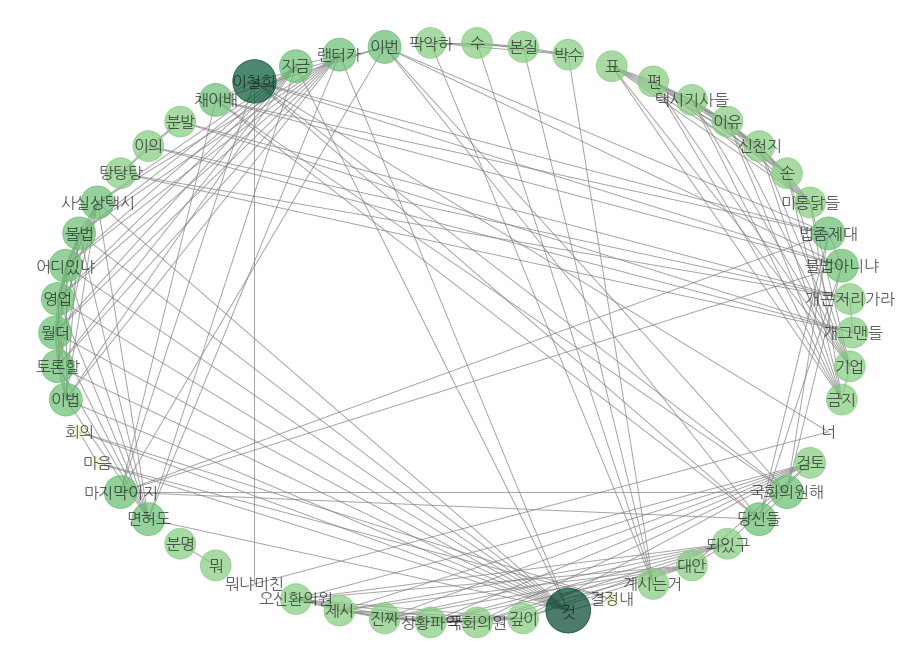

In [38]:
plt.figure(figsize=(16,12))
plt.axis('off')
nx.draw_networkx(G, font_family=font_name, font_size=16,
                pos=pos, node_color=list(pr.values()), node_size=nsize,
                alpha = 0.7, edge_color='.5', cmap=plt.cm.YlGn)

### 4. 결론

#### 1) 형태소 분석 결과
- 예상과 달리, '타다' 단어 언급 빈도가 저조
- 이유: KoNLPy 패키지에서 '타다'를 동사로 인식하여, 분류 오류 발생.
 - '타다는' -> '타' + '다는'
 - '타다' -> '타' + '다'

#### 2) 워드 클라우드 분석 결과
- 택시, 불법, 기사, 혁신 등이 많이 언급 되었음.
- 중간 발표 때, '타다'는 불법이라고 하는 여론과, 혁신적이라고 하는 여론이 양립되어 있을 것으로 예상하였다. 
- 크롤링 개별 영상 댓글에서 유튜브 댓글 트렌드를 확인한 결과, '불법'과 '혁신'이라는 단어의 빈도 수가 높은 것으로 관찰되었다.

#### 3) 단어 별 네트워크 분석 결과
- 이철희, 채이배 의원: 언급 빈도가 많고, 두 사람에 대한 연관성이 있는 것으로 보임.
- 실제로, 두 의원이 주도하여 타다 금지법 법사위 통과 반대한 것으로 확인.  
    

#### 4) 유튜브 크롤링 시세(티끌모아 태산)

In [1]:
%%html
<iframe src = "https://kmong.com/gig/186921" width="1000px", height ="800px" ;"></iframe>

### 5. 보완점

#### 1) 기술
- scrapy: 
 - spider.py에서 한 개의 동영상 댓글을 크롤링하면 잘 가져와지나, 여러 개의 링크 동영상을 가져오면 각 링크 별로 일부의 댓글들만 추출되는 문제 확인. 유튜브 api로 1회 크롤링 시 50개의 댓글 제한이 있는데, 이와 유사한 문제로 추측.
- crontab 설정을 통해 주기적으로 댓글 수집. 댓글 수집 완료되면 메신저로 메시지 보내기.

#### 2) 분석
 - 자연어 처리: 특정 단어 인식 문제 발생. 직접 사전 구축하여 처리 필요.
 - 감성 분석: 긍정/부정, 분류 모델(나이브 베이즈, Dictionary 기반 감성분석) 사용하여 추후 분석 예정.